# Исследование надежности заемщиков

## Введение

Заказчик проекта — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Так же просят выяснить есть ли зависимость между уровнем дохода и возвратом кредита в срок и целью кредита и возвратом кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.
Результаты исследования будут учтены при построении модели кредитного скоринга — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Обзор данных

In [1]:
import pandas as pd
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('/datasets/data.csv')

# Посмотрим на общую информацию по базе
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


В таблице чуть больше 21 тысячи записей. Колонок в таблице 12, названия придерживаются единой стилистики. В нескольких колонках присутствуют пропуски. Среди типов используемых данных есть целые числа, вещественные числа и строки.

In [4]:
# Отобразим первые пять строк с начала и конца таблицы
df

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,-4529.316663,43,среднее,1,гражданский брак,1,F,компаньон,0,224791.862382,операции с жильем
21521,0,343937.404131,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999.806512,сделка с автомобилем
21522,1,-2113.346888,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672.561153,недвижимость
21523,3,-3112.481705,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093.050500,на покупку своего автомобиля


В документации к таблице указано, что колонки обозначают следующие данные:

* `children` — количество детей в семье
* `days_employed` — общий трудовой стаж в днях
* `dob_years` — возраст клиента в годах
* `education` — уровень образования клиента
* `education_id` — идентификатор уровня образования
* `family_status` — семейное положение
* `family_status_id` — идентификатор семейного положения
* `gender` — пол клиента
* `income_type` — тип занятости
* `debt` — имел ли задолженность по возврату кредитов
* `total_income` — ежемесячный доход
* `purpose` — цель получения кредита

Замеченные странности:

`days_employed` - почему-то трудовой стаж указан в виде числа дней с шестью знаками после запятой. Логичным кажется указание количества дней в виде целого числа. Так же непонятно, почему некоторые значения в данной колонке - отрицательные. 

Еще обращают на себя внимание данные в строках №4 и №21521. Если перевести дни трудового стажа из строки №21521 в года, то получится: 343937 / 365 = 942,3 года трудового стажа. Хммм... Наверное так не должно быть🙃. 

Явная ошибка в данных. Можно сделать вывод, что нам точно не стоит использовать в расчётах по данной колонке среднее значение.

Заметка для администраторов БД: 942 года трудового стажа выглядит как явная ошибка, которая может сказываться на многих вычислениях, связанных с данной таблицей. Считаю, что имеет смысл открыть тикет на поиск и устранение причины появления таких данных.

## Предобработка данных

### Заполнение пропусков

In [5]:
# Взглянем на количество пропусков в данных
df.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

В колонках `days_employed` и `total_income` пропущено одинаковое количество строк: 2174. В обоих колонках пропущенные значения являются вещественными числами.

Заметка для администраторов БД: возможно пропуски в данных колонках как-то взаимосвязаны, раз число пропусков одинаково. Может быть эта информация поможет найти и исправить проблему.

In [6]:
# Посчитаем долю пропущенных строк от общего количества строк
empty_rows = df['days_employed'].isna().sum()
total_rows = df.shape[0]
empty_rows_in_percent = round(empty_rows / total_rows * 100, 1)
f'Процент пропущенных строк от общего числа строк составляет: {empty_rows_in_percent}%'

'Процент пропущенных строк от общего числа строк составляет: 10.1%'

Считаю, что 10 процентов - это весомое количество данных. Имеет смысл заполнить пропуски вместо того, чтобы просто удалить строки.

Посмотрим на эти строки, возможно получится выявить какую-либо закономерность и предположить причины появления пропусков:

In [7]:
# Отобразим пропущенные строки
df[df.isna().any(axis=1)]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,среднее,1,гражданский брак,1,M,пенсионер,0,NaN,сыграть свадьбу
26,0,NaN,41,среднее,1,женат / замужем,0,M,госслужащий,0,NaN,образование
29,0,NaN,63,среднее,1,Не женат / не замужем,4,F,пенсионер,0,NaN,строительство жилой недвижимости
41,0,NaN,50,среднее,1,женат / замужем,0,F,госслужащий,0,NaN,сделка с подержанным автомобилем
55,0,NaN,54,среднее,1,гражданский брак,1,F,пенсионер,1,NaN,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
21489,2,NaN,47,Среднее,1,женат / замужем,0,M,компаньон,0,NaN,сделка с автомобилем
21495,1,NaN,50,среднее,1,гражданский брак,1,F,сотрудник,0,NaN,свадьба
21497,0,NaN,48,ВЫСШЕЕ,0,женат / замужем,0,F,компаньон,0,NaN,строительство недвижимости
21502,1,NaN,42,среднее,1,женат / замужем,0,F,сотрудник,0,NaN,строительство жилой недвижимости


Какой-то явной связи между строками с пропущенными данными не наблюдается. Сделать какое-то предположение о причине появления пропусков затруднительно.

В количественных переменных заполнять пропуски лучше медианным значением из-за возможного присутствия значений, которые сильно отклоняются в какую-либо сторону от большинства значений. Ниже будет явно видно один из таких примеров.

### Проверка данных на аномалии и исправления

#### Столбец children

In [8]:
# Посмотрим статистику по столбцу children
df['children'].describe()

count    21525.000000
mean         0.538908
std          1.381587
min         -1.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         20.000000
Name: children, dtype: float64

Есть явные странности: значения -1 и 20.

In [9]:
# Посчитаем сколько раз встречаются разные значения в столбце children
df['children'].value_counts()

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

Несколько десятков строк, в которых число детей указано 20 (это чересчур много) и -1 (явная ошибка). 

In [10]:
# Посчитаем отношение аномальных строк ко всем строкам
anomaly_children_row_count = (df[df['children'] == 20]['children'].count() + 
                              df[df['children'] == -1]['children'].count())
anomaly_percent = round(anomaly_children_row_count / df.shape[0] * 100, 3)
f'Процент строк с аномальным количеством детей, по отношению ко всей таблице составляет: {anomaly_percent}%'

'Процент строк с аномальным количеством детей, по отношению ко всей таблице составляет: 0.571%'

In [11]:
# Перед заменой значений вызовем несколько строк, в которых указано количество детей == 20
# Это необходимо для проверки корректности замены
df[df['children'] == 20].head(5)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
606,20,-880.221113,21,среднее,1,женат / замужем,0,M,компаньон,0,145334.865002,покупка жилья
720,20,-855.595512,44,среднее,1,женат / замужем,0,F,компаньон,0,112998.738649,покупка недвижимости
1074,20,-3310.411598,56,среднее,1,женат / замужем,0,F,сотрудник,1,229518.537004,получение образования
2510,20,-2714.161249,59,высшее,0,вдовец / вдова,2,F,сотрудник,0,264474.835577,операции с коммерческой недвижимостью
2941,20,-2161.591519,0,среднее,1,женат / замужем,0,F,сотрудник,0,199739.941398,на покупку автомобиля


In [12]:
# Заменим 20 на 2, а -1 на 1. Выведем все значения для проверки.
df.loc[df['children'] == 20, ['children']] = 2
df.loc[df['children'] == -1, ['children']] = 1
df['children'].value_counts()

0    14149
1     4865
2     2131
3      330
4       41
5        9
Name: children, dtype: int64

In [13]:
# Проверим, что в таблице замена прошла корректно
df.loc[[606, 720, 1074, 2510, 2941]]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
606,2,-880.221113,21,среднее,1,женат / замужем,0,M,компаньон,0,145334.865002,покупка жилья
720,2,-855.595512,44,среднее,1,женат / замужем,0,F,компаньон,0,112998.738649,покупка недвижимости
1074,2,-3310.411598,56,среднее,1,женат / замужем,0,F,сотрудник,1,229518.537004,получение образования
2510,2,-2714.161249,59,высшее,0,вдовец / вдова,2,F,сотрудник,0,264474.835577,операции с коммерческой недвижимостью
2941,2,-2161.591519,0,среднее,1,женат / замужем,0,F,сотрудник,0,199739.941398,на покупку автомобиля


#### Столбец days_employed

Перейдём к столбцу `days_employed`

In [14]:
# Посмотрим статистику по столбцу days_employed
df['days_employed'].describe()

count     19351.000000
mean      63046.497661
std      140827.311974
min      -18388.949901
25%       -2747.423625
50%       -1203.369529
75%        -291.095954
max      401755.400475
Name: days_employed, dtype: float64

В столбце присутствуют отрицательные значения, исправим это:

In [15]:
# Заменим отрицательные числовые значения на абсолютные и посмотрим на статистику по столбцу после изменений
df['days_employed'] = df['days_employed'].abs()
df['days_employed'].describe()

count     19351.000000
mean      66914.728907
std      139030.880527
min          24.141633
25%         927.009265
50%        2194.220567
75%        5537.882441
max      401755.400475
Name: days_employed, dtype: float64

На себя обращает внимание максимальное значение в столбце. Если перевести эти дни в года, то получится 401755 / 365 =  1100 лет. Явная ошибка, которая тянет за собой среднее значение по столбцу вверх. Среднее количество дней равняется 66914 дней (или 183 года). Проводить расчёты исходя из среднего значения данного столбца будет ошибочно, поэтому будем использовать медианное значение, которое равно 2194 дня или 6 лет.

In [16]:
# Заполним пропущенные значения медианой и проверим, что пропусков не осталось
df['days_employed'] = df['days_employed'].fillna(df['days_employed'].median())
sum_na = df['days_employed'].isna().sum()
f'Количество пропущенных значений в столбце \'days_employed\': {sum_na}'

"Количество пропущенных значений в столбце 'days_employed': 0"

#### Столбец total_income

Тоже самое проделаем со столбцом total_income

In [17]:
# Посмотрим статистику по столбцу total_income
df['total_income'].describe()

count    1.935100e+04
mean     1.674223e+05
std      1.029716e+05
min      2.066726e+04
25%      1.030532e+05
50%      1.450179e+05
75%      2.034351e+05
max      2.265604e+06
Name: total_income, dtype: float64

Явных аномалий здесь не видно, просто заполним пропущенные значения медианой

In [18]:
# Заполним пропущенные значения медианой и проверим, что пропусков не осталось
df['total_income'] = df['total_income'].fillna(df['total_income'].median())
sum_na = df['total_income'].isna().sum()
f'Количество пропущенных значений в столбце \'total_income\': {sum_na}'

"Количество пропущенных значений в столбце 'total_income': 0"

In [19]:
# Ещё раз проверим, что пропущенных значений в таблице не осталось
df.isna().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

### Столбец dob_years

In [20]:
# Проверим ещё и столбец dob_years
df['dob_years'].describe()

count    21525.000000
mean        43.293380
std         12.574584
min          0.000000
25%         33.000000
50%         42.000000
75%         53.000000
max         75.000000
Name: dob_years, dtype: float64

Обращает внимание минимальное значение - 0 лет. В остальном данные выглядят вполне достоверными. 

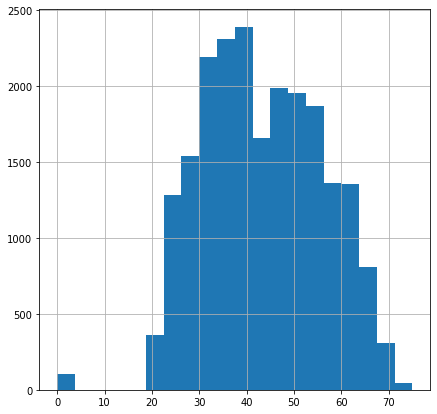

In [21]:
# Оценим распределение значений на гистограмме
df['dob_years'].hist(bins=20, figsize=(7, 7))

Возраст заёмщиков похож на нормальное распределение, за исключением ряда нулевых значений. Всего таких записей около 100. Заменим их на медиану.

In [22]:
# Заменим нулевые значения на медиану. Выведем все значения для проверки.
df.loc[df['dob_years'] == 0, ['dob_years']] = df['dob_years'].median()
df['dob_years'].describe()

count    21525.000000
mean        43.490453
std         12.218595
min         19.000000
25%         34.000000
50%         42.000000
75%         53.000000
max         75.000000
Name: dob_years, dtype: float64

С данной колонкой закончили.

### Изменение типов данных

Число дней трудового стажа в столбце days_employed по какой-то причине записано как вещественное число. Хотя на практике в трудовой книжке указывается всегда целое число дней. Приведем тип данных в данном столбце к целому числу.

In [23]:
# Приведём тип данных в столбце к целочисленному, вместо вещественного и отобразим полученный результат
df['days_employed'] = df['days_employed'].astype('int')
df['days_employed']

0          8437
1          4024
2          5623
3          4124
4        340266
          ...  
21520      4529
21521    343937
21522      2113
21523      3112
21524      1984
Name: days_employed, Length: 21525, dtype: int64

Так же приведём к целочисленному типу столбец total_income

In [24]:
# Приведём тип данных в столбце к целочисленному, вместо вещественного и отобразим полученный результат
df['total_income'] = df['total_income'].astype('int')
df['total_income']

0        253875
1        112080
2        145885
3        267628
4        158616
          ...  
21520    224791
21521    155999
21522     89672
21523    244093
21524     82047
Name: total_income, Length: 21525, dtype: int64

### Удаление дубликатов

In [25]:
# Проверим наличие строк-дубликатов в таблице
f'Количество строк-дубликатов в таблице: {df.duplicated().sum()}'

'Количество строк-дубликатов в таблице: 55'

In [26]:
# Удалим строки-дубликаты, сбросим индексы и проверим снова таблицу
df = df.drop_duplicates().reset_index(drop=True)
f'Количество строк-дубликатов в таблице: {df.duplicated().sum()}'

'Количество строк-дубликатов в таблице: 0'

In [27]:
# Проверим на дубликаты столбец education
df['education'].value_counts()

среднее                13704
высшее                  4710
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   273
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
УЧЕНАЯ СТЕПЕНЬ             1
Ученая степень             1
Name: education, dtype: int64

Можно заметить, что не хватает единого стиля написания категорий. 

In [28]:
# Приведём весь столбец к единообразному формату и отобразим полученный результат
df.loc[:, 'education'] = df.loc[:, 'education'].str.lower()
df['education'].value_counts()

среднее                15187
высшее                  5251
неоконченное высшее      744
начальное                282
ученая степень             6
Name: education, dtype: int64

In [29]:
# Проверим датасет на дубликаты ещё раз
f'Количество строк-дубликатов в таблице: {df.duplicated().sum()}'

'Количество строк-дубликатов в таблице: 17'

In [30]:
# Удалим строки-дубликаты ещё раз, сбросим индексы и проверим снова таблицу
df = df.drop_duplicates().reset_index(drop=True)
f'Количество строк-дубликатов в таблице: {df.duplicated().sum()}'

'Количество строк-дубликатов в таблице: 0'

In [31]:
# Проверим на дубликаты столбец family_status
df['family_status'].value_counts()

женат / замужем          12339
гражданский брак          4150
Не женат / не замужем     2810
в разводе                 1195
вдовец / вдова             959
Name: family_status, dtype: int64

Здесь дубликатов не наблюдается

In [32]:
# Проверим на дубликаты столбец income_type
df['income_type'].value_counts()

сотрудник          11083
компаньон           5078
пенсионер           3829
госслужащий         1457
безработный            2
предприниматель        2
студент                1
в декрете              1
Name: income_type, dtype: int64

Здесь так же дубликатов не наблюдается

In [33]:
# Проверим на дубликаты столбец purpose
df['purpose'].value_counts()

свадьба                                   791
на проведение свадьбы                     767
сыграть свадьбу                           765
операции с недвижимостью                  675
покупка коммерческой недвижимости         661
операции с жильем                         652
покупка жилья для сдачи                   651
операции с коммерческой недвижимостью     650
покупка жилья                             646
жилье                                     646
покупка жилья для семьи                   638
строительство собственной недвижимости    635
недвижимость                              633
операции со своей недвижимостью           627
строительство жилой недвижимости          624
покупка недвижимости                      621
покупка своего жилья                      620
строительство недвижимости                619
ремонт жилью                              607
покупка жилой недвижимости                606
на покупку своего автомобиля              505
заняться высшим образованием      

Присутствует явное смысловое дублирование. В дальнейшем буду избавляться от него.

Для поиска дубликатов в таблице был использован метод `duplicated()`, который размечает всю таблицу как 'True/False', где 'True' помечаются строки, которые полностью дублированы.  
Для поиска дубликатов в колонках был использован метод `value_counts()`, который подсчитывает уникальные значения в колонке и выводит их в формате таблицы, где первая колонка - это значение, а вторая - количество раз, которое данное значение встречается в колонке.

Предположу, что причиной появления дубликатов является ручной ввод данных в некоторых колонках. Было бы практичнее вводить данные в данных колонках через выбор одного из доступных, заранее написанных значений.

### Формирование дополнительных датафреймов словарей, декомпозиция исходного датафрейма.

In [34]:
# Создадим отдельный датафрейм с категориями образования
education_dict = df[['education_id', 'education']]
education_dict = education_dict.drop_duplicates().reset_index(drop=True)
education_dict

,education_id,education
0,0,высшее
1,1,среднее
2,2,неоконченное высшее
3,3,начальное
4,4,ученая степень


In [35]:
# Создадим отдельный датафрейм с категориями семейного положения
family_status_dict = df[['family_status_id', 'family_status']]
family_status_dict = family_status_dict.drop_duplicates().reset_index(drop=True)
family_status_dict

,family_status_id,family_status
0,0,женат / замужем
1,1,гражданский брак
2,2,вдовец / вдова
3,3,в разводе
4,4,Не женат / не замужем


In [36]:
# Удалим столбцы education и family_status из основного датафрейма, 
# т.к. они нам там больше не нужны и посмотрим на результат
df = df.drop(['education', 'family_status'], axis=1)
df

,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437,42.0,0,0,F,сотрудник,0,253875,покупка жилья
1,1,4024,36.0,1,0,F,сотрудник,0,112080,приобретение автомобиля
2,0,5623,33.0,1,0,M,сотрудник,0,145885,покупка жилья
3,3,4124,32.0,1,0,M,сотрудник,0,267628,дополнительное образование
4,0,340266,53.0,1,1,F,пенсионер,0,158616,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...
21448,1,4529,43.0,1,1,F,компаньон,0,224791,операции с жильем
21449,0,343937,67.0,1,0,F,пенсионер,0,155999,сделка с автомобилем
21450,1,2113,38.0,1,1,M,сотрудник,1,89672,недвижимость
21451,3,3112,38.0,1,0,M,сотрудник,1,244093,на покупку своего автомобиля


### Категоризация дохода.

Дополнительные датафреймы созданы. Теперь добавим столбец `total_income_category` с категориями в зависимости от дохода кредитополучателя.

In [37]:
def set_total_income_category(total_income: int) -> str:
    """
    В зависимости от значения в столбце total_income,
    присваивается одно из значение ниже в столбец total_income_category:
    0–30000 — 'E';
    30001–50000 — 'D';
    50001–200000 — 'C';
    200001–1000000 — 'B';
    1000001 и выше — 'A'.
    Например, кредитополучателю с доходом 25000 нужно назначить категорию 'E', а клиенту, получающему 235000, — 'B'
    """
    try:
        if 0 <= total_income <= 30000:
            return 'E'
        elif 30001 <= total_income <= 50000:
            return 'D'
        elif 50001 <= total_income <= 200000:
            return 'C'
        elif 200001 <= total_income <= 1000000:
            return 'B'
        elif 1000001 <= total_income:
            return 'A'
        else:
            return 'None'
    except Error:
        print(f'Неккоректное значение: {total_income}')

In [38]:
# Применим функцию set_total_income_category к новому столбцу total_income_category
df['total_income_category'] = df['total_income'].apply(set_total_income_category)
df

,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose,total_income_category
0,1,8437,42.0,0,0,F,сотрудник,0,253875,покупка жилья,B
1,1,4024,36.0,1,0,F,сотрудник,0,112080,приобретение автомобиля,C
2,0,5623,33.0,1,0,M,сотрудник,0,145885,покупка жилья,C
3,3,4124,32.0,1,0,M,сотрудник,0,267628,дополнительное образование,B
4,0,340266,53.0,1,1,F,пенсионер,0,158616,сыграть свадьбу,C
...,...,...,...,...,...,...,...,...,...,...,...
21448,1,4529,43.0,1,1,F,компаньон,0,224791,операции с жильем,B
21449,0,343937,67.0,1,0,F,пенсионер,0,155999,сделка с автомобилем,C
21450,1,2113,38.0,1,1,M,сотрудник,1,89672,недвижимость,C
21451,3,3112,38.0,1,0,M,сотрудник,1,244093,на покупку своего автомобиля,B


In [39]:
# Убедимся, что в колонке нет пропущенных значений после применения функции
result = df['total_income_category'].isna().sum()
f'Пропущенных значений: {result}'

'Пропущенных значений: 0'

### Категоризация целей кредита.

Теперь добавим новый столбец `purpose_category`, в котором в зависимости от значения в столбцу `purpose` будем определять категорию кредита.  


Категории будут следующие:
* `'операции с автомобилем'`,
* `'операции с недвижимостью'`,
* `'проведение свадьбы'`,
* `'получение образования'`.

In [40]:
# Определим функцию set_purpose_category
def set_purpose_category(purpose: str) -> str:
    """
    Если в строке `purpose` содержится строка слева от дефиса,
    то возвращается категория справа от дефиса:
    'автомобил' - 'операции с автомобилем',
    'жиль','недвижимост' - 'операции с недвижимостью',
    'свадьб' - 'проведение свадьбы',
    'образовани' - 'получение образования'
    """
    try:
        if 'автомобил' in purpose:
            return 'операции с автомобилем'
        elif 'жиль' in purpose or 'недвижимост' in purpose:
            return 'операции с недвижимостью'
        elif 'свадьб' in purpose:
            return 'проведение свадьбы'
        elif 'образовани' in purpose:
            return 'получение образования'
        else:
            return 'None'
    except Error:
        print(f'Неккоректное значение: {purpose}')

In [41]:
# Применим функцию set_purpose_category к новому столбцу purpose_category
df['purpose_category'] = df['purpose'].apply(set_purpose_category)
df

,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose,total_income_category,purpose_category
0,1,8437,42.0,0,0,F,сотрудник,0,253875,покупка жилья,B,операции с недвижимостью
1,1,4024,36.0,1,0,F,сотрудник,0,112080,приобретение автомобиля,C,операции с автомобилем
2,0,5623,33.0,1,0,M,сотрудник,0,145885,покупка жилья,C,операции с недвижимостью
3,3,4124,32.0,1,0,M,сотрудник,0,267628,дополнительное образование,B,получение образования
4,0,340266,53.0,1,1,F,пенсионер,0,158616,сыграть свадьбу,C,проведение свадьбы
...,...,...,...,...,...,...,...,...,...,...,...,...
21448,1,4529,43.0,1,1,F,компаньон,0,224791,операции с жильем,B,операции с недвижимостью
21449,0,343937,67.0,1,0,F,пенсионер,0,155999,сделка с автомобилем,C,операции с автомобилем
21450,1,2113,38.0,1,1,M,сотрудник,1,89672,недвижимость,C,операции с недвижимостью
21451,3,3112,38.0,1,0,M,сотрудник,1,244093,на покупку своего автомобиля,B,операции с автомобилем


In [42]:
# Убедимся, что в колонке нет пропущенных значений после применения функции
result = df['purpose_category'].isna().sum()
f'Пропущенных значений: {result}'

'Пропущенных значений: 0'

### Заключение по предобработке датасета

В данных были обнаружены пропуски, аномалии, несоответствие типов данных и дубликаты.
Пропуски в данных составили около 10% от общего количества данных, они были заполнены медианой. 
Аномалии заключались в отрицательных значениях, нулевых значениях и неккоретных значениях.
Дубликаты были удалены. Тип данных нескольких столбцов был изменён. 

Аномалии в данных скорее всего были вызваны некорректным заполнением базы данных. Эти ошибки в данных серьезно могут влиять на аналитические вычисления, связанные с данной базой данных. Рекомендуется открыть тикет на поиск и исправление возможных причин ошибочных данных.

## Ответы на вопросы.

### Вопрос 1:

Есть ли зависимость между количеством детей и возвратом кредита в срок?

In [43]:
# Создадим сводную таблицу, где посчитаем и просуммируем количество задолжностей с учетом количества детей у заёмщика
debt_children_pivot = df.pivot_table(index='children', values='debt', margins=True, aggfunc=['count', 'sum'])
debt_children_pivot

,count,sum
,debt,debt
children,,
0,14090,1063
1,4855,445
2,2128,202
3,330,27
4,41,4
5,9,0
All,21453,1741


Описание столбцов:
* `children` - количество детей у заёмщика
* `count debt` - количество заёмщиков с соответствующим количеством детей
* `sum debt` - количество заёмщиков, которые не вернули кредит в срок. 


Количество заёмщиков, которые не вернули кредит в срок получается посчитать, потому как в основной таблице в колонке `debt` есть только два значения:
* `1` - задолжность есть
* `0` - задолжности нет  

В результате суммирования значений становится понятно количество должников.

In [44]:
# Добавим колонку `ratio`, в которой посчитаем отношение кол-ва должников к общему количеству заёмщиков в %
debt_children_pivot['ratio'] = debt_children_pivot['sum']['debt'] / debt_children_pivot['count']['debt'] * 100
debt_children_pivot

,count,sum,ratio
,debt,debt,
children,,,
0,14090,1063,7.544358
1,4855,445,9.165808
2,2128,202,9.492481
3,330,27,8.181818
4,41,4,9.756098
5,9,0,0.000000
All,21453,1741,8.115415


Процент должников колеблется между 7 и 9 процентами. Уже можно сделать вывод о том, что количество детей не влияет на возврат кредита. Но я хочу ещё посмотреть статистику по данной колонке. Удалим строку с заёмщиками, у которых 5 детей - их всего 9 человек (0.04% от общего количества должников), и долгов у них нет, т.е. процент должников равен нулю. Если оставить данную строку, то на статистике это значение скажется не лучшим образом. 

In [45]:
# Удалим строку с заёмщиками, у которых 5 детей и посмотрим на статистику по колонке
debt_children_pivot = debt_children_pivot.drop(5)
debt_children_pivot['ratio'].describe()

count    6.000000
mean     8.709330
std      0.883808
min      7.544358
25%      8.132016
50%      8.673813
75%      9.410813
max      9.756098
Name: ratio, dtype: float64

Стандартное отконение по статистике составляет всего лишь 0,88% (строка `std`).

### Вывод 1:

В зависимости от количества детей, количество должников различается в среднем на 0,88%. Это очень небольшое значение, которое говорит о том, что количество детей не влияет на возврат кредита в срок.

### Вопрос 2:

Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [46]:
# Создадим сводную таблицу, где посчитаем и просуммируем количество задолжностей с учетом семейного положения
debt_family_status_pivot = df.pivot_table(index='family_status_id', values='debt', margins=True, aggfunc=['count', 'sum'])
debt_family_status_pivot

,count,sum
,debt,debt
family_status_id,,
0,12339,931
1,4150,388
2,959,63
3,1195,85
4,2810,274
All,21453,1741


In [47]:
# Добавим колонку `ratio`, в которой посчитаем отношение кол-ва должников к общему количеству заёмщиков в %
debt_family_status_pivot['ratio'] = debt_family_status_pivot['sum']['debt'] / debt_family_status_pivot['count']['debt'] * 100
debt_family_status_pivot

,count,sum,ratio
,debt,debt,
family_status_id,,,
0,12339,931,7.545182
1,4150,388,9.349398
2,959,63,6.569343
3,1195,85,7.112971
4,2810,274,9.750890
All,21453,1741,8.115415


In [48]:
# Добавим колонку family_status из словаря family_status_dict для наглядности
debt_family_status_pivot = debt_family_status_pivot.merge(family_status_dict, on='family_status_id', how='left')
debt_family_status_pivot

,family_status_id,"(count, debt)","(sum, debt)","(ratio, )",family_status
0,0,12339,931,7.545182,женат / замужем
1,1,4150,388,9.349398,гражданский брак
2,2,959,63,6.569343,вдовец / вдова
3,3,1195,85,7.112971,в разводе
4,4,2810,274,9.750890,Не женат / не замужем
5,All,21453,1741,8.115415,NaN


In [49]:
# Посмотрим статистику по колонке ratio
debt_family_status_pivot['ratio', ''].describe()

count    6.000000
mean     8.073866
std      1.257580
min      6.569343
25%      7.221024
50%      7.830299
75%      9.040902
max      9.750890
Name: (ratio, ), dtype: float64

### Вывод 2:

Стандартное отклонение составляет 1.24%. Т.е. количество должников, в среднем, различается на 1.24% в зависимости от семейного статуса. Делаю вывод, что семейное положение не оказывает влияния на возврат кредита.

### Вопрос 3:

Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [50]:
# Создадим сводную таблицу, где посчитаем и просуммируем количество задолжностей в различных категориях дохода
debt_income_category_pivot = df.pivot_table(index='total_income_category', values='debt', margins=True, aggfunc=['count', 'sum'])
debt_income_category_pivot

,count,sum
,debt,debt
total_income_category,,
A,25,2
B,5041,356
C,16015,1360
D,350,21
E,22,2
All,21453,1741


In [51]:
# Добавим колонку `ratio`, в которой посчитаем отношение кол-ва должников к общему количеству заёмщиков в %
debt_income_category_pivot['ratio'] = debt_income_category_pivot['sum']['debt'] / debt_income_category_pivot['count']['debt'] * 100
debt_income_category_pivot

,count,sum,ratio
,debt,debt,
total_income_category,,,
A,25,2,8.000000
B,5041,356,7.062091
C,16015,1360,8.492039
D,350,21,6.000000
E,22,2,9.090909
All,21453,1741,8.115415


In [52]:
# Посмотрим статистику по колонке ratio
debt_income_category_pivot['ratio', ''].describe()

count    6.000000
mean     7.793409
std      1.101735
min      6.000000
25%      7.296568
50%      8.057708
75%      8.397883
max      9.090909
Name: (ratio, ), dtype: float64

### Вывод 3:

Стандартное отклонение составляет 1.09%. Т.е. количество должников, в среднем, различается на 1.09% в зависимости от уровня дохода. Делаю вывод, что уровень дохода не оказывает влияния на возврат кредита.

### Вопрос 4:

Как разные цели кредита влияют на его возврат в срок?

In [53]:
# Создадим сводную таблицу, где посчитаем и просуммируем количество задолжностей с учётом цели, ради которой брался кредит
debt_purpose_category_pivot = df.pivot_table(index='purpose_category', values='debt', margins=True, aggfunc=['count', 'sum'])
debt_purpose_category_pivot

,count,sum
,debt,debt
purpose_category,,
операции с автомобилем,4306,403
операции с недвижимостью,10811,782
получение образования,4013,370
проведение свадьбы,2323,186
All,21453,1741


In [54]:
# Добавим колонку `ratio`, в которой посчитаем отношение кол-ва должников к общему количеству заёмщиков в %
debt_purpose_category_pivot['ratio'] = debt_purpose_category_pivot['sum']['debt'] / debt_purpose_category_pivot['count']['debt'] * 100
debt_purpose_category_pivot

,count,sum,ratio
,debt,debt,
purpose_category,,,
операции с автомобилем,4306,403,9.359034
операции с недвижимостью,10811,782,7.233373
получение образования,4013,370,9.220035
проведение свадьбы,2323,186,8.006888
All,21453,1741,8.115415


In [55]:
# Посмотрим статистику по колонке ratio
debt_purpose_category_pivot['ratio', ''].describe()

count    5.000000
mean     8.386949
std      0.892734
min      7.233373
25%      8.006888
50%      8.115415
75%      9.220035
max      9.359034
Name: (ratio, ), dtype: float64

### Вывод 4:

Стандартное отклонение составляет 0.9%. Т.е. количество должников, в среднем, различается на 0.9% в зависимости от цели кредита. Это несущественное различие между различными категориями займа. Делаю вывод, что цель кредита не оказывает влияния на возврат кредита в срок.

## Общий вывод:

Были проведены исследования, отвечающие на следующие вопросы:
1. Существует ли зависимость между количеством детей у заёмщика и возвратом кредита в срок?
2. Существует ли зависимость между семейным положением заёмщика и возвратом кредита в срок?
3. Существует ли зависимость между уровнём дохода заёмщика и возвратом кредита в срок?
4. Существует ли зависимость между различными целями кредита и возвратом кредита в срок?

По результатам исследований вывод следующий: зависимостей ни в одном из случаев не было установлено. Во всех случаях различия в количестве должников составляло около 1%, что сложно назвать значимой величиной. Признаки, которые могут оказывать влияние на возврат кредита в срок не были обнаружены. 